In [13]:
# data processing
import pandas as pd
import numpy as np
import json

# modelling
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report, auc, roc_curve, accuracy_score, precision_recall_curve, precision_recall_fscore_support
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
mnist = keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Dataset split: 60000 train rows
Dataset split: 10000 test rows


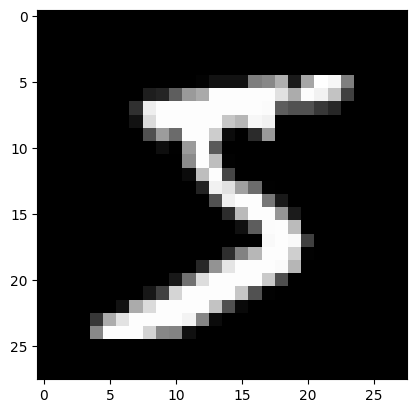

In [15]:
print(f"Dataset split: {len(x_train)} train rows")
print(f"Dataset split: {len(x_test)} test rows")

point = x_train[0].reshape(28, 28)

plt.imshow(point, cmap='gray')
plt.show()

In [16]:
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [17]:
# Normalize pixel values to the range [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# reshape the data
x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)

In [18]:
input_img = keras.layers.Input(shape=(784,))
encoded = keras.layers.Dense(256, activation='relu')(input_img)
encoded = keras.layers.Dense(128, activation='relu')(encoded)
encoded = keras.layers.Dense(64, activation='relu')(encoded)
encoded = keras.layers.Dense(32, activation='relu')(encoded)

In [19]:
decoded = keras.layers.Dense(64, activation='relu')(encoded)
decoded = keras.layers.Dense(128, activation='relu')(decoded)
decoded = keras.layers.Dense(256, activation='relu')(decoded)
decoded = keras.layers.Dense(784, activation='sigmoid')(decoded)

In [20]:
autoencoder = keras.models.Model(input_img, decoded)

In [21]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [22]:
autoencoder.fit(x_train, x_train, epochs=20, batch_size=64, shuffle=True, validation_data=(x_test, x_test))

Epoch 1/20


938/938 [==============================] - 4s 4ms/step - loss: 0.0366 - val_loss: 0.0207
Epoch 2/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0178 - val_loss: 0.0149
Epoch 3/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0140 - val_loss: 0.0127
Epoch 4/20
938/938 [==============================] - 3s 4ms/step - loss: 0.0121 - val_loss: 0.0113
Epoch 5/20
938/938 [==============================] - 3s 4ms/step - loss: 0.0110 - val_loss: 0.0104
Epoch 6/20
938/938 [==============================] - 3s 4ms/step - loss: 0.0102 - val_loss: 0.0099
Epoch 7/20
938/938 [==============================] - 3s 4ms/step - loss: 0.0096 - val_loss: 0.0096
Epoch 8/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0092 - val_loss: 0.0090
Epoch 9/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0089 - val_loss: 0.0087
Epoch 10/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0086 - val_loss: 0.0085
Epoch 11/2

In [23]:
decoded_imgs = autoencoder.predict(x_test)

313/313 [==============================] - 0s 1ms/step


In [24]:
reconstruction_errors = np.mean(np.square(x_test - decoded_imgs), axis=1)

In [25]:
threshold = np.percentile(reconstruction_errors, 95)

In [26]:
# Identify anomalies based on the threshold
anomaly_indexes = np.where(reconstruction_errors > threshold)[0]

In [27]:
# Get all the anomalies from the test_images
anomalies = x_test[anomaly_indexes]

# Create binary labels where 1 represents anomalies and 0 represents non-anomalies
anomaly_labels = np.where(reconstruction_errors > threshold, 1, 0)

In [28]:
print(len(anomalies))

500


In [45]:
# Get anomaly labels
label_of_anomalies = y_test[anomaly_indexes]

# create a dict of indexes and labels
anomaly_dict = dict(zip(map(int, anomaly_indexes), label_of_anomalies))

In [53]:
anomaly_dict_serializable = {int(key): str(value) for key, value in anomaly_dict.items()}

In [54]:
# write to json file
json_filename = "anomalies.json"
with open(json_filename, 'w') as json_file:
    json.dump(anomaly_dict_serializable, json_file)

print(f"Anomaly dictionary saved to {json_filename}")

Anomaly dictionary saved to anomalies.json


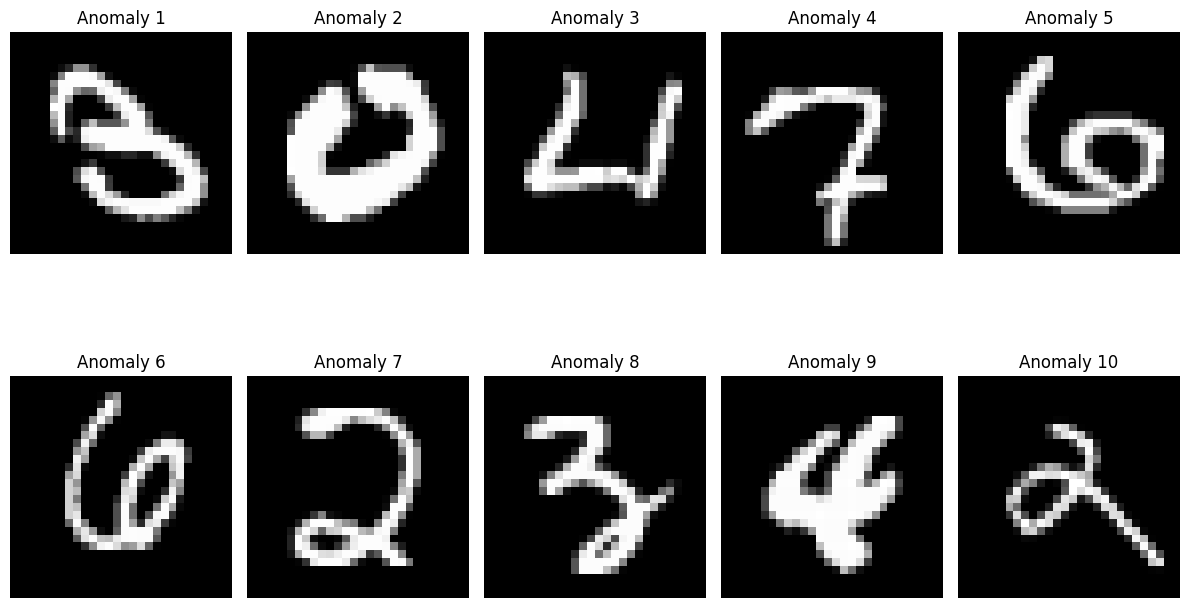

In [55]:
# Plot some of the anomalies
plt.figure(figsize=(12, 8))
for i, idx in enumerate(anomaly_indexes[:10]):  # Plot the first 10 anomaly indices
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_test[idx].reshape(28, 28), cmap='gray')
    plt.title(f'Anomaly {i+1}')
    plt.axis('off')
plt.tight_layout()
plt.show()

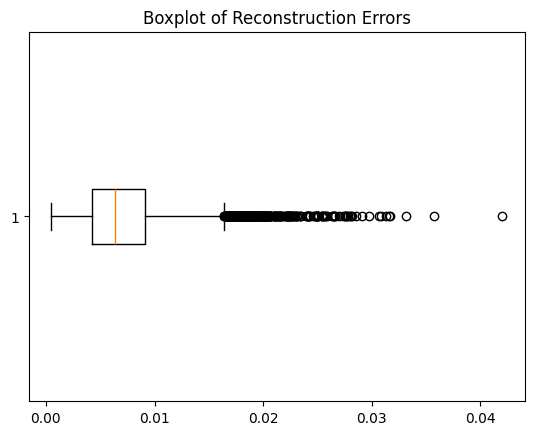

In [56]:
# Add a boxplot using reconstruction error values
plt.boxplot(reconstruction_errors, vert=False)
plt.title("Boxplot of Reconstruction Errors")
plt.show()

In [57]:
# Make a ROC curve and calculate the area under the curve (AUC)
y_true = [1 if i in anomalies else 0 for i in range(len(x_test))]

# calculate the precision, recall, and f1 score
precision, recall, f1, _ = precision_recall_fscore_support(y_true, anomaly_labels)

# print precision, recall, and f1 score
print(f'Precision: {precision[1]:.2f}')
print(f'Recall: {recall[1]:.2f}')
print(f'F1 Score: {f1[1]:.2f}')

Precision: 0.00
Recall: 0.00
F1 Score: 0.00


In [58]:
# calculate the precision and recall for different threshold levels
precision, recall, thresholds = precision_recall_curve(y_true, reconstruction_errors)

# calculate the area under the precision-recall curve
pr_auc = auc(recall, precision)

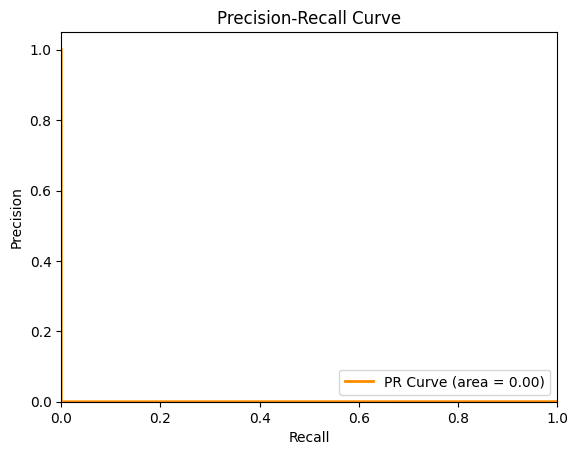

In [59]:
# Plot the precision-recall curve
plt.figure()
plt.plot(recall, precision, color='darkorange', lw=2, label='PR Curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower right')
plt.show()

In [60]:
# classification report, binary labels where 1 represents anomalies and 0 represents non-anomalies
anomaly_labels = np.where(reconstruction_errors > threshold, 1, 0)
report = classification_report(y_true, anomaly_labels)
print(report)


              precision    recall  f1-score   support

           0       1.00      0.95      0.97      9998
           1       0.00      0.00      0.00         2

    accuracy                           0.95     10000
   macro avg       0.50      0.47      0.49     10000
weighted avg       1.00      0.95      0.97     10000

